# Random Forest Analysis for Predicting Atrrition

## Project Overview
This notebook presents a comprehensive analysis of a companies attriction prediction through the use of Random Forest algorithm to uncover hidden factors that influences employee to stay or leave the organization


## Contents
1. Introduction to Random Forest
2. Data Loading and Exploration
3. Data Preprocessing
4. Exploratory Data Analysis
5. Random Forest Implementation
6. Model Evaluation
7. Feature Importance Analysis
8. Business Insights and Recommendations
9. Conclusion

## 1. Introduction to Random Forest

### What is Random Forest?
Random Forest is an ensemble learning method that operates by constructing multiple decision trees during training and outputting the mean prediction (for regression problems) or the mode prediction (for classification problems) of the individual trees.

### Mathematical Intuition

#### Decision Trees Basics
A decision tree makes decisions by splitting the data based on feature values. For a regression tree with a dataset $(X, Y)$ where $X$ represents features and $Y$ represents the target value:

1. The algorithm seeks to find the split that minimizes the sum of squared errors (SSE):
   $$SSE = \sum_{i \in left}(y_i - \bar{y}_{left})^2 + \sum_{i \in right}(y_i - \bar{y}_{right})^2$$
   
   where $\bar{y}_{left}$ and $\bar{y}_{right}$ are the mean values in the left and right nodes after the split.

#### Random Forest Algorithm
Random Forest extends decision trees through:

1. **Bagging (Bootstrap Aggregating)**: Training each tree on a random sample with replacement from the original dataset.
   - If our original dataset has $n$ observations, each bootstrap sample also has $n$ observations, but some observations may be repeated and some may be left out.
   
2. **Feature Randomization**: At each split in each tree, only considering a random subset of features.
   - If there are $m$ features, typically we consider $\sqrt{m}$ features at each split.

3. **Ensemble Prediction**: For regression, the final prediction is the average of predictions from all trees:
   $$\hat{y} = \frac{1}{B} \sum_{b=1}^{B} \hat{y}_b$$
   where $B$ is the number of trees and $\hat{y}_b$ is the prediction from the $b$-th tree.

### Key Advantages of Random Forest
1. **Reduced Overfitting**: By averaging multiple trees, the model reduces variance while maintaining low bias
2. **Feature Importance**: Provides a measure of the importance of each feature
3. **Out-of-Bag (OOB) Error Estimation**: Built-in validation using samples not included in individual tree training
4. **Handles Non-linear Relationships**: Effectively captures complex patterns in data
5. **Robust to Outliers**: Less sensitive to extreme values than linear models

### Out-of-Bag (OOB) Error Estimation
When building each tree, approximately 1/3 of the data is not used (out-of-bag). These samples can be used to estimate model performance:

1. For each observation $(x_i, y_i)$, find all trees where this observation was OOB
2. Average the predictions from these trees for $x_i$
3. Calculate the error between this prediction and $y_i$
4. Average these errors across all observations

This provides an unbiased estimate of the model's performance without requiring a separate validation set.

### Majority Voting
In Random Forest classification:
- Each tree "votes" for a class
- The final prediction is the class with the most votes (majority voting)

For regression, the equivalent is taking the average of all tree predictions.

## 2. Data Loading and Exploration


# 3. Random Forest Implementation in python

We will use Decision Tree & Random Forest in Predicting the attrition of your valuable employees.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

In [13]:
df = pd.read_csv("/content/WA_Fn-UseC_-HR-Employee-Attrition.csv")
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [14]:
df.shape

(1470, 35)

# Exploratory Data Analysis

<Axes: xlabel='Attrition', ylabel='count'>

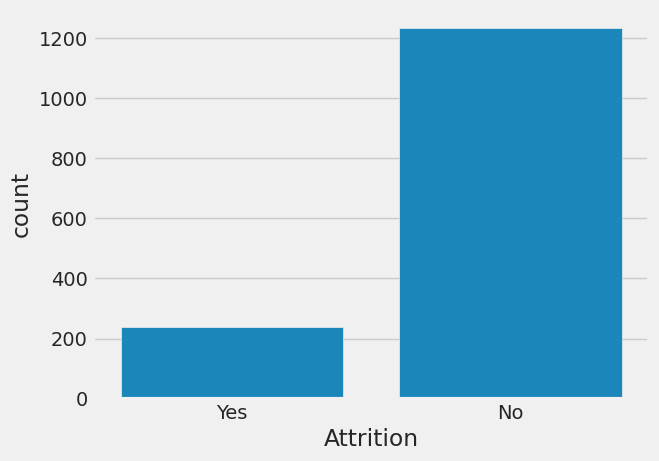

In [15]:
sns.countplot(x='Attrition', data=df)

In [16]:
df.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis="columns", inplace=True)

categorical_col = []
for column in df.columns:
    if df[column].dtype == object and len(df[column].unique()) <= 50:
        categorical_col.append(column)

df['Attrition'] = df.Attrition.astype("category").cat.codes

# Data Processing

In [17]:
categorical_col.remove('Attrition')

In [18]:
# Transform categorical data into dummies
# categorical_col.remove("Attrition")
# data = pd.get_dummies(df, columns=categorical_col)
# data.info()
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
for column in categorical_col:
    df[column] = label.fit_transform(df[column])

In [19]:
from sklearn.model_selection import train_test_split

X = df.drop('Attrition', axis=1)
y = df.Attrition

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Applying Tree & Random Forest algorithms

## 1. Decision Tree Classifier

**Decision Tree parameters:**
- `criterion`: The function to measure the quality of a split. Supported criteria are "`gini`" for the Gini impurity and "`entropy`" for the information gain.
***
- `splitter`: The strategy used to choose the split at each node. Supported strategies are "`best`" to choose the best split and "`random`" to choose the best random split.
***
- `max_depth`: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than `min_samples_split` samples.
***
- `min_samples_split`: The minimum number of samples required to split an internal node.
***
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least ``min_samples_leaf`` training samples in each of the left and right branches.  This may have the effect of smoothing the model, especially in regression.
***
- `min_weight_fraction_leaf`: The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.
***
- `max_features`: The number of features to consider when looking for the best split.
***
- `max_leaf_nodes`: Grow a tree with ``max_leaf_nodes`` in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
***
- `min_impurity_decrease`: A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
***
- `min_impurity_split`: Threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf.

# 3. Random Forest

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

- **Random forest algorithm parameters:**
- `n_estimators`: The number of trees in the forest.
***
- `criterion`: The function to measure the quality of a split. Supported criteria are "`gini`" for the Gini impurity and "`entropy`" for the information gain.
***
- `max_depth`: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than `min_samples_split` samples.
***
- `min_samples_split`: The minimum number of samples required to split an internal node.
***
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least ``min_samples_leaf`` training samples in each of the left and right branches.  This may have the effect of smoothing the model, especially in regression.
***
- `min_weight_fraction_leaf`: The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.
***
- `max_features`: The number of features to consider when looking for the best split.
***
- `max_leaf_nodes`: Grow a tree with ``max_leaf_nodes`` in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
***
- `min_impurity_decrease`: A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
***
- `min_impurity_split`: Threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf.
***
- `bootstrap`: Whether bootstrap samples are used when building trees. If False, the whole datset is used to build each tree.
***
- `oob_score`: Whether to use out-of-bag samples to estimate the generalization accuracy.

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")

    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, y_train)

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    853.0  176.0       1.0     1029.0        1029.0
_______________________________________________
Confusion Matrix: 
 [[853   0]
 [  0 176]]

Test Result:
Accuracy Score: 86.17%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.870070   0.500000  0.861678    0.685035      0.818881
recall       0.986842   0.081967  0.861678    0.534405      0.861678
f1-score     0.924784   0.140845  0.861678    0.532815      0.816348
support    380.000000  61.000000  0.861678  441.000000    441.000000
_______________________________________________
Conf

## 4. Random Forest hyperparameter tuning

### a) Randomized Search Cross Validation

`Random search` allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with `GridSearchCV`, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define.

# Summary
In this notebook we learned the following lessons:
- Decsion tree and random forest algorithms and the parameters of each algorithm.
- How to tune hyperparameters for both Decision tree and Random Forest.
- Balance your dataset before training to prevent the tree from being biased toward the classes that are dominant.
  - By sampling an equal number of samples from each class  
  - By normalizing the sum of the sample weights (sample_weight) for each class to the same value.
